# Sistemas de Recomendación - Netflix Prize Challenge

## Filtro Colaborativo a partir de descomposición UV

En este notebook vamos a implementar un sistema de recomendación usando un método tipo descomposición UV.

Vamos a usar la biblioteca Surprise. Te recomendamos tener abierta la [documentación](https://surprise.readthedocs.io/en/stable/getting_started.html) a medida que vas recorriendo esta sección.

### 1. Dataset y Train/test split

Carga de datos

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [50]:
df1 = pd.read_csv('netflix-prize-data/combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [51]:
df_title = pd.read_csv('netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos? Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [52]:
reader = Reader()

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

In [85]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'Movie_id', 'Rating']][:N_filas], reader)

In [86]:
type(data)

surprise.dataset.DatasetAutoFolds

¿Cómo les parece que es mejor hacer el split?¿Dejando películas en test, usuarios o combinaciones?

In [54]:
trainset, testset = train_test_split(data, test_size=.25)

### 2.2 Entrenamiento

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [55]:
from surprise import SVD
algo = SVD()

Entrenamos sobre el `trainset`

In [56]:
algo.fit(trainset)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [57]:
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [58]:
predictions[1]

Prediction(uid=2313468, iid=28, r_ui=5.0, est=3.909084255658973, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función `predict`

In [59]:
algo.predict(1539350,269)

Prediction(uid=1539350, iid=269, r_ui=None, est=3.5321066666666665, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles películas le gustaron y cuáles les recomienda el sistema.

Películas que le gustaron

In [60]:
usuario = 1539350
rating = 5
df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]

,User,Rating,Movie_id
1183325,1539350,5,269
1219057,1539350,5,270
2170404,1539350,5,406
6183892,1539350,5,1202
14863884,1539350,5,2862
16327782,1539350,5,3151
18779767,1539350,5,3605
20899561,1539350,5,3928
22114087,1539350,5,4159


In [61]:
usuario = 1539350
rating = 5   # le pedimos peliculas a las que haya puesto 4 o 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.Movie_id].values
df_user

,User,Rating,Movie_id,Name
0,1539350,5,269,Parenthood
1,1539350,5,270,Sex and the City: Season 4
2,1539350,5,406,Hostage
3,1539350,5,1202,National Lampoon's Vacation
4,1539350,5,2862,The Silence of the Lambs
5,1539350,5,3151,Napoleon Dynamite
6,1539350,5,3605,The Wizard of Oz: Collector's Edition
7,1539350,5,3928,Nip/Tuck: Season 2
8,1539350,5,4159,Barbershop


Creamos donde vamos a guardar las recomendaciones

In [62]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Sacamos del dataframe todas las películas que ya sabemos que vio

In [63]:
usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,Movie_id
219870,1539350,3,33
409717,1539350,4,111
445206,1539350,3,127
664099,1539350,4,175
894718,1539350,4,197


In [64]:
recomendaciones_usuario.head(269)

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW
...,...
265,The Jeff Corwin Experience: Costa Rica and the...
266,Saudade Do Futuro
267,Touched by an Angel: Season 1


In [65]:
#recomendaciones_usuario.drop(usuario_vistas.Movie_id, inplace = True)
recomendaciones_usuario.head(275)
recomendaciones_usuario[recomendaciones_usuario.Name == "Parenthood"]

,Name
Movie_Id,
269,Parenthood


In [66]:
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


Y hacemos las recomendaciones

In [67]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: algo.predict(usuario, x).est)

In [68]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,Movie_Id,Name,Estimate_Score
12,13,Lord of the Rings: The Return of the King: Ext...,4.522198
4,5,The Rise and Fall of ECW,4.063015
24,25,Inspector Morse 31: Death Is Now My Neighbour,4.002527
27,28,Lilo and Stitch,3.909084
0,1,Dinosaur Planet,3.836271
29,30,Something's Gotta Give,3.768449
17,18,Immortal Beloved,3.738318
1,2,Isle of Man TT 2004 Review,3.704521
28,29,Boycott,3.691680
2,3,Character,3.685134


In [71]:
df1

,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1
...,...,...,...
24053759,2591364,2,4499
24053760,1791000,2,4499
24053761,512536,5,4499
24053762,988963,3,4499


### 2. Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas. Para eso, buscar en la documentación cómo se hace.

In [72]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 1.0508


1.0508056952700358

### 3. Optimización de parámetros

**Ejercicio**: hacer un gráfico del desempeño del modelo en función del número de factores del `SVD`

In [87]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for f in factores:
    print(f)
    algo = SVD(n_factors=f)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0492  1.0419  1.0416  1.0442  0.0035  
Fit time          1.01    1.00    1.05    1.02    0.02    
Test time         0.23    0.22    0.35    0.27    0.06    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0429  1.0461  1.0444  1.0445  0.0013  
Fit time          1.12    1.01    1.08    1.07    0.05    
Test time         0.22    0.22    0.21    0.22    0.00    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0416  1.0506  1.0474  1.0466  0.0037  
Fit time          1.13    1.10    1.10    1.11    0.02    
Test time         0.22    0.37    0.22    0.27    0.07    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0466  1.0

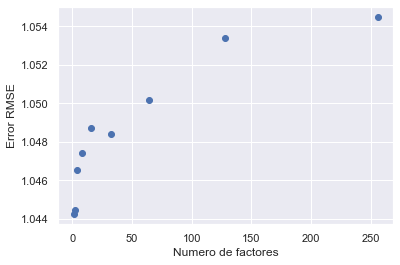

In [88]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**Ejercicio**: recordar que, cuando entrenamos un `SVD`, estamos usando descenso por gradiente para minimizar una función de costo. Usar `GridSearchCV` para buscar valores óptimos para los siguientes parámetros (tres por parámetros, utilizar los valores default de referencia): `n_factors`, `n_epochs`, `lr_all` y `reg_all`. Estudiar qué representa cada uno de ellos mientras esperan. Vaya a preparar el mate.

In [90]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5,50,100], 'lr_all': [0.001,0.002,0.005],
              'reg_all': [0.002,0.02,0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [91]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.04418750108005
{'n_factors': 5, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.2}


## Extra: Agrandando el Dataset

Podemos sumar al dataset el resto de las calificaciones que no usamos.

Como corremos el riesgo de que se nos llene la memoria RAM, vamos a hacerlo de a poco y con cuidado. Arrancamos agregando las calificaciones que hay en `combined_data_2.txt`.

0. Reiniciar el Kernel
1. Abrir el archivo `combined_data_2.txt` con la función `load_data`.
2. Agregar una columna con el `Movie_id` al que corresponden las calificaciones. Si te animas, puedes crear una función que realice este paso.
3. Opcional: filtrar películas con pocas calificaciones
4. Abrir el archivo donde ya está procesado `combined_data_1.txt`. 
5. Agregar al final las nuevas calificaciones y guardarlo en un nuevo archivo.


Una vez que estén contentos con el procedimientos, repetir los pasos anteriores para los archivos faltantes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [3]:
### 1
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    return df

df2 = load_data('netflix-prize-data/combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [4]:
### 2.
movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [5]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [6]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805], dtype=int64)

In [7]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [8]:
df2['Movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['Movie_id'] = df2['Movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

91

In [9]:
df2

,User,Rating,Movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [10]:
### 4.

df1 = pd.read_csv('netflix-prize-data/combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'Movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [11]:
### 5.

df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

(51031355, 3)


Chequeamos que estén todas las películas:

In [12]:
peliculas_presentes = df.Movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int16)

In [13]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


Y guardamos

In [14]:
if True:
    df.to_csv('netflix-prize-data/combined_data_1y2_with_movie_id.csv', index= False)